In [1]:
import collections
import gc
import re

import cufflinks as cf
import jieba
import matplotlib
import matplotlib.pyplot as plt
import missingno as msno
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud

%matplotlib inline
cf.go_offline()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('max_colwidth',200)
plt.style.use('seaborn')

第一次玩DF,发一个简单的疫情文本EDA试试。如果有帮助请点个赞。

## 读取数据

由于其他编码会出现少部分汉字乱码，比如“XX超话”、表情符号等。所以我手动用记事本转换成了 UTF-8 编码。

其中，超话以及其他特殊字符以“”表示，大部分表情符号被“??”代替。

In [2]:
train_labeled = pd.read_csv('./input/train_dataset/nCoV_100k_train_labled_utf8.csv', encoding='utf-8')
train_labeled.rename(columns = {"微博id": "Weibo_ID",
                                "微博发布时间": "Publish_Time", 
                                "发布人账号": "Account_ID",
                                "微博中文内容": "Chinese_Content",
                                "微博图片": "Pictures",
                                "微博视频": "Videos",
                                "情感倾向": "Labels"},  inplace=True)

train_labeled_copy = train_labeled.copy()

In [3]:
test = pd.read_csv('./input/test_dataset/nCov_10k_test_utf8.csv', encoding='utf-8')
test.rename(columns = {"微博id": "Weibo_ID",
                                "微博发布时间": "Publish_Time", 
                                "发布人账号": "Account_ID",
                                "微博中文内容": "Chinese_Content",
                                "微博图片": "Pictures",
                                "微博视频": "Videos"},  inplace=True)

test_copy = test.copy()

In [4]:
train_labeled.head(3)

,Weibo_ID,Publish_Time,Account_ID,Chinese_Content,Pictures,Videos,Labels
0,4456072029125500,01月01日 23:50,存曦1988,写在年末冬初孩子流感的第五天，我们仍然没有忘记热情拥抱这2020年的第一天。带着一丝迷信，早晨给孩子穿上红色的羽绒服羽绒裤，祈祷新的一年，孩子们身体康健。仍然会有一丝焦虑，焦虑我的孩子为什么会过早的懂事，从两岁多开始关注我的情绪，会深沉地说：妈妈，你终于笑了！这句话像刀子一样扎入我?展开全文c,['https://ww2.sinaimg.cn/orj360/005VnA1zly1gahhwworn5j30m80fyq4n.jpg'],[],0
1,4456074167480980,01月01日 23:58,LunaKrys,开年大模型…累到以为自己发烧了腰疼膝盖疼腿疼胳膊疼脖子疼#Luna的Krystallife#?,[],[],-1
2,4456054253264520,01月01日 22:39,小王爷学辩论o_O,邱晨这就是我爹，爹，发烧快好，毕竟美好的假期拿来养病不太好，假期还是要好好享受快乐，爹，新年快乐，发烧好了就去浪吧，快快乐乐的度过这个美好假期，说不定以后就没有了嗷@邱晨虫仔2泉州·泉州理工学院?,"['https://ww2.sinaimg.cn/thumb150/006ymYXKgy1gahft9xvnbj31o00u0jxt.jpg', 'https://ww1.sinaimg.cn/thumb150/006ymYXKgy1gahftblqogj31o00u0agj.jpg', 'https://ww4.sinaimg.cn/thumb150/006ymYXKgy1gahftdd...",[],1


In [5]:
test.head(3)

,Weibo_ID,Publish_Time,Account_ID,Chinese_Content,Pictures,Videos
0,4456068992182160,01月01日 23:38,-精緻的豬豬女戰士-,#你好2020#新年第一天元气满满的早起出门买早饭结果高估了自己抗冻能力回家成功冻发烧（大概是想告诉我2020要量力而行）然鹅这并不影响后续计划一出门立马生龙活虎新年和新??更配哦??看了误杀吃了大餐就让新的一年一直这样美滋滋下去吧???,"['https://ww2.sinaimg.cn/thumb150/745aa591ly1gahhjvh2k7j211u0u0th2.jpg', 'https://ww3.sinaimg.cn/thumb150/745aa591ly1gahhjb3ueqj20u0140dnn.jpg', 'https://ww2.sinaimg.cn/orj360/745aa591ly1gahhjar7n...",[]
1,4456424178427250,01月02日 23:09,liujunyi88,大宝又感冒鼻塞咳嗽了，还有发烧。队友加班几天不回。感觉自己的情绪在家已然是随时引爆的状态。情绪一上来，容易对孩子说出自己都想不到的话来……2020年，真的要学会控制情绪，管理好家人健康。这是今年最大的目标。?,[],[]
2,4456797466940200,01月03日 23:53,ablsa,还要去输两天液，这天也太容易感冒发烧了，一定要多喝热水啊?,['https://ww3.sinaimg.cn/orj360/006fTidCly1gajt7wulilj31o01o07wh.jpg'],[]


## 缺失值检查

检查一下训练集和测试集的缺失值，可以看出有些数据是缺失的。

In [6]:
train_labeled.isnull().any()

Weibo_ID           False
Publish_Time       False
Account_ID         False
Chinese_Content     True
Pictures           False
Videos             False
Labels              True
dtype: bool

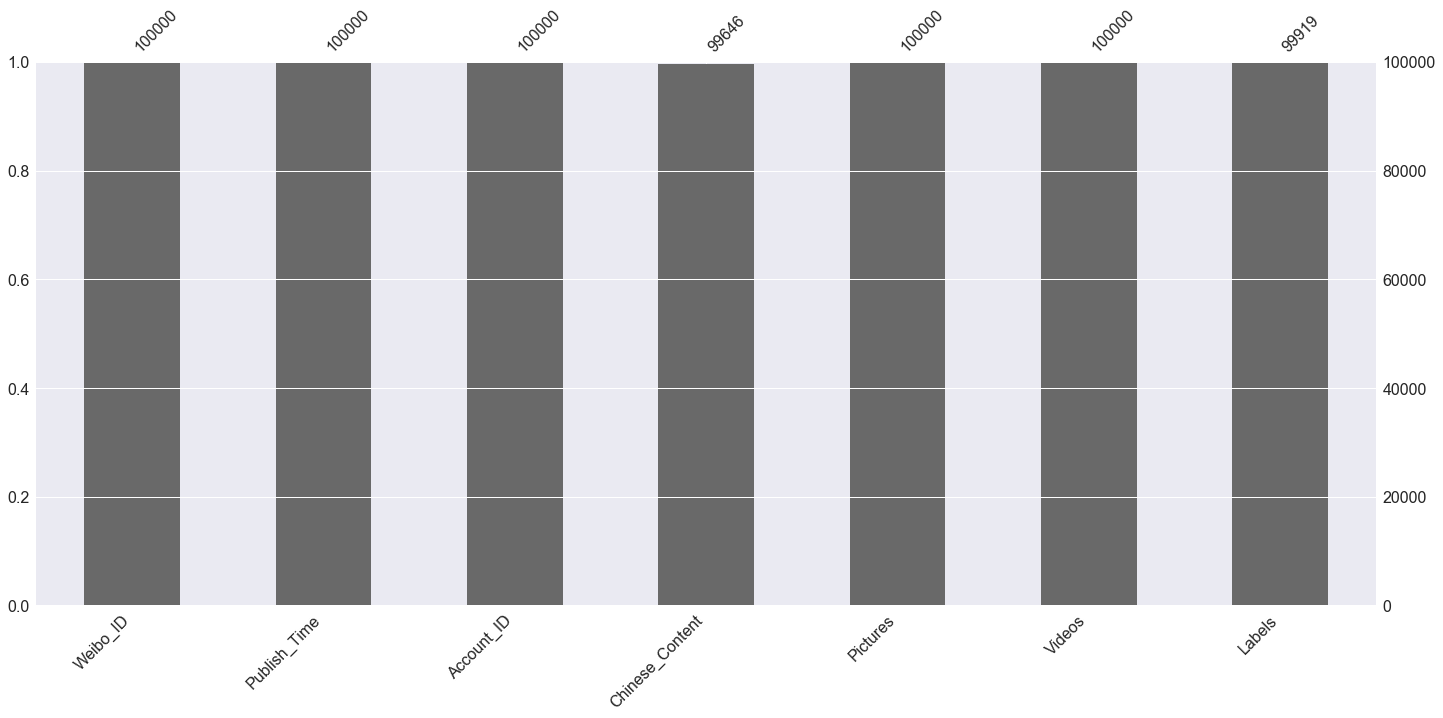

In [7]:
msno.bar(train_labeled)

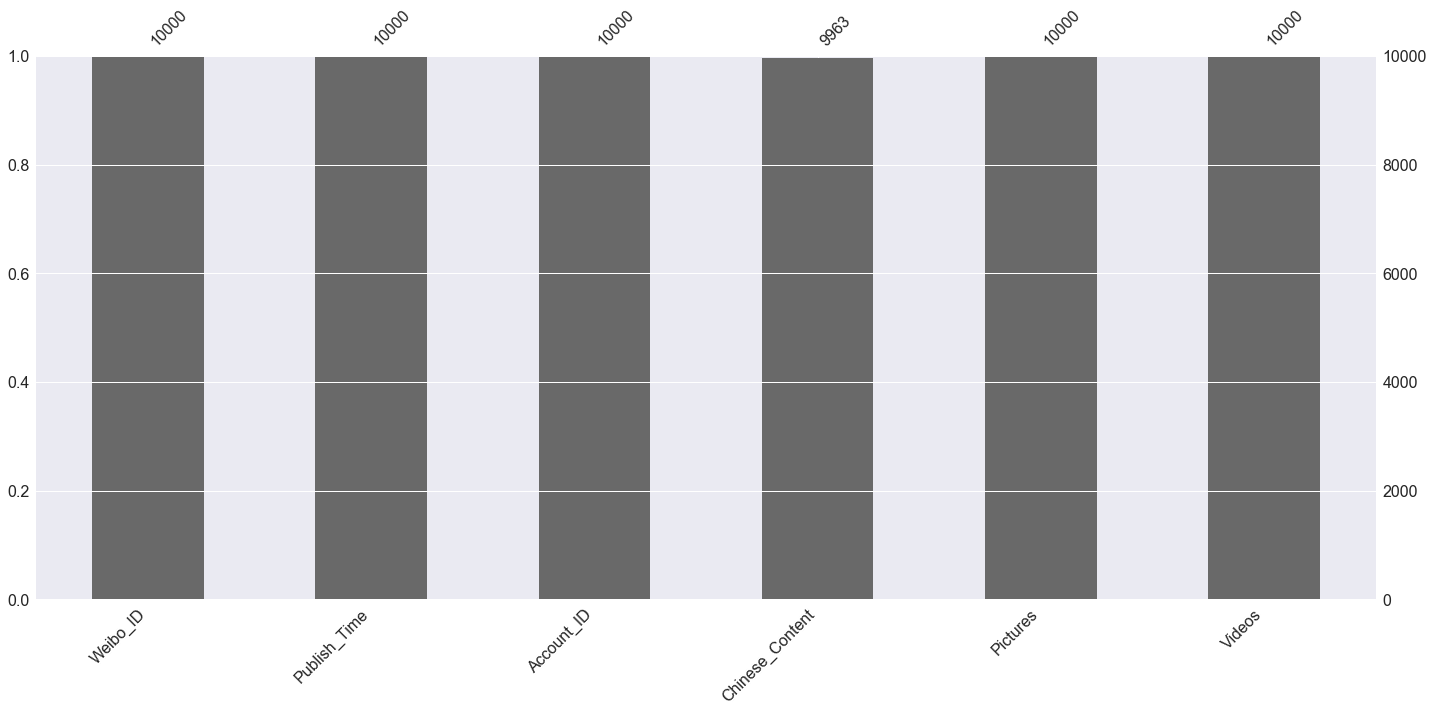

In [8]:
msno.bar(test)

有少量微博正文数据丢失，部分labels为空。

## 标签检查

标签统计如下：

In [9]:
train_labeled_copy.fillna({"Labels": "empty_label"}, inplace=True)

temp = train_labeled_copy["Labels"].value_counts()
temp_df = pd.DataFrame({'labels': temp.index,
                        'values': temp.values})

temp_df.iplot(kind='pie',labels='labels',values='values', title='Labels')

有6种噪音标签，每种各一个，此外还有一点点空标签，统计如下:

In [10]:
noise = train_labeled_copy[(train_labeled_copy["Labels"] != '0') & 
                           (train_labeled_copy["Labels"] != '1') & 
                           (train_labeled_copy["Labels"] != '-1')]

noise = noise["Labels"].value_counts()
noise_df = pd.DataFrame({'labels': noise.index,
                         'values': noise.values})

noise_df.iplot(kind='pie',labels='labels',values='values', title='奇怪标签统计')

对于非正常标签的处理，可以直接舍弃，也可以手工打上真正标签（如果不嫌累）。

这里我们直接舍弃就行。

## 发微博数量与时间关系

疫情和时间的分析用了包佬的代码。（你的代码很不错，不过下一秒就是我的了.jpg）

In [11]:
train_labeled_copy['time'] = pd.to_datetime('2020年' + train_labeled['Publish_Time'], format='%Y年%m月%d日 %H:%M', errors='ignore')
test_copy['time'] = pd.to_datetime('2020年' + train_labeled['Publish_Time'], format='%Y年%m月%d日 %H:%M', errors='ignore')

In [12]:
train_labeled_copy['month'] =  train_labeled_copy['time'].dt.month
train_labeled_copy['day'] =  train_labeled_copy['time'].dt.day
train_labeled_copy['dayfromzero']  = (train_labeled_copy['month'] - 1) * 31 +  train_labeled_copy['day']

test_copy['month'] =  test_copy['time'].dt.month
test_copy['day'] =  test_copy['time'].dt.day
test_copy['dayfromzero']  = (test_copy['month'] - 1) * 31 +  test_copy['day']

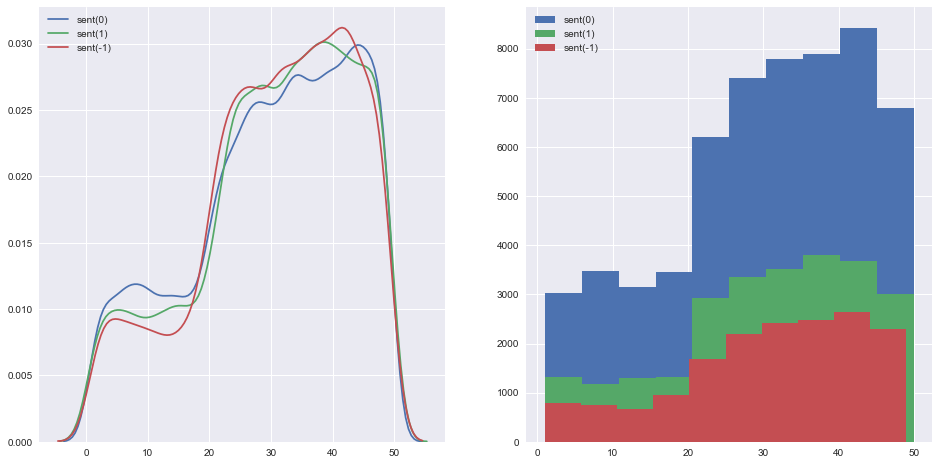

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.kdeplot(train_labeled_copy.loc[train_labeled_copy['Labels'] == '0', 'dayfromzero'], ax=ax[0], label='sent(0)')
sns.kdeplot(train_labeled_copy.loc[train_labeled_copy['Labels'] == '1', 'dayfromzero'], ax=ax[0], label='sent(1)')
sns.kdeplot(train_labeled_copy.loc[train_labeled_copy['Labels'] == '-1', 'dayfromzero'], ax=ax[0], label='sent(-1)')

train_labeled_copy.loc[train_labeled_copy['Labels'] == '0', 'dayfromzero'].hist(ax=ax[1])
train_labeled_copy.loc[train_labeled_copy['Labels'] == '1', 'dayfromzero'].hist(ax=ax[1])
train_labeled_copy.loc[train_labeled_copy['Labels'] == '-1', 'dayfromzero'].hist(ax=ax[1])
ax[1].legend(['sent(0)', 'sent(1)','sent(-1)'])

plt.show()

可以看出如下情况，顺便也帮大家找了找相关新闻节点（深藏功与名）：

- **1月18日**后，话题量有明显增长。
    - 1月19日：武汉CDC李刚：新冠人传人风险较低，传染力不强。
    - 1月20日：钟南山:新型肺炎存在人传人现象。
    - 1月20日：口罩出现抢购现象。
    - 1月23日：武汉封城。
    - 1月25日：火神山医院设计方案完成；雷神山医院建造决定。

- **二月九日**前后，话题量达到顶峰。
    - 2月7日：“吹哨人”李文亮医生不幸去世。
    - 2月10日：湖北省相关领导任免。

18日前官方口径（包括网友）们的态度还比较乐观，大部分认为“新冠可防可控”、“传染力有限”，然后钟南山院士对新冠“肯定存在人传人”的表态可能是导致话题量飙升的重要原因。

7日晚上李文亮医生不幸去世，微博和朋友圈都在刷屏，从曲线上看，相关话题量几乎到达顶峰。

（**悼念李文亮医生**）

## 正文长度统计

现在开始统计相关微博的长度，训练集和测试集都有。

In [14]:
train_labeled_copy['Chinese_Content_Length'] = train_labeled['Chinese_Content'].astype(str).apply(len)
test_copy['Chinese_Content_Length'] = train_labeled['Chinese_Content'].astype(str).apply(len)

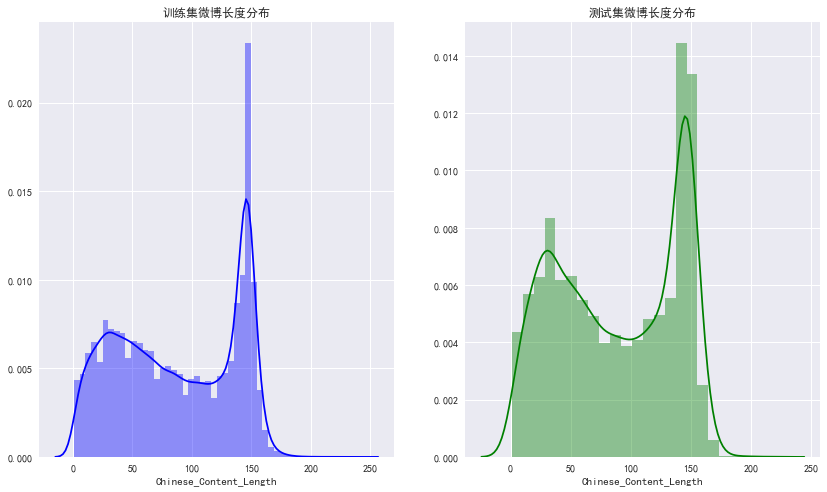

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,8))
sns.distplot(train_labeled_copy['Chinese_Content_Length'], ax=ax1, color='blue')
sns.distplot(test_copy['Chinese_Content_Length'], ax=ax2, color='green')

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

ax1.set_title('训练集微博长度分布')
ax2.set_title('测试集微博长度分布')

plt.show()

看出点什么东西没？

### 正文词云

采用 `jieba` 和 `wordcloud` 对正文做一个词云。

In [84]:
stop = open('stopwords.txt', 'r+', encoding='utf-8')
jieba.add_word("赖美云")
stopword = stop.read().split("\n")
stopeword = set(stopword)
stop.close()

In [17]:
def stripword(seg):
    """停用词处理"""
    wordlist = []
    
    for key in seg.split(' '):
        #去除停用词和单字
        if not (key.strip() in stopword) and (len(key.strip()) > 1):
            wordlist.append(key)
    return ' '.join(wordlist)

def cutword(content):
    """分词，去除停用词，写得比较简陋"""
    seg_list = jieba.cut(content)
    line = " ".join(seg_list)
    word = stripword(line)
    return word

In [18]:
train_labeled_copy['Chinese_Content_cut'] = train_labeled['Chinese_Content'].astype(str).apply(cutword)

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\杨岱川\AppData\Local\Temp\jieba.cache
Loading model cost 0.799 seconds.
Prefix dict has been built successfully.


In [19]:
train_labeled_copy.head(3)

,Weibo_ID,Publish_Time,Account_ID,Chinese_Content,Pictures,Videos,Labels,time,month,day,dayfromzero,Chinese_Content_Length,Chinese_Content_cut
0,4456072029125500,01月01日 23:50,存曦1988,写在年末冬初孩子流感的第五天，我们仍然没有忘记热情拥抱这2020年的第一天。带着一丝迷信，早晨给孩子穿上红色的羽绒服羽绒裤，祈祷新的一年，孩子们身体康健。仍然会有一丝焦虑，焦虑我的孩子为什么会过早的懂事，从两岁多开始关注我的情绪，会深沉地说：妈妈，你终于笑了！这句话像刀子一样扎入我?展开全文c,['https://ww2.sinaimg.cn/orj360/005VnA1zly1gahhwworn5j30m80fyq4n.jpg'],[],0,2020-01-01 23:50:00,1,1,1,147,年末 冬初 孩子 流感 第五天 我们 仍然 没有 忘记 热情 拥抱 2020 第一天 一丝 迷信 早晨 孩子 红色 羽绒服 羽绒 祈祷 一年 孩子 身体 康健 仍然 一丝 焦虑 焦虑 孩子 为什么 过早 懂事 两岁 开始 关注 情绪 深沉 地说 妈妈 终于 这句 刀子 一样 扎入 展开 全文
1,4456074167480980,01月01日 23:58,LunaKrys,开年大模型…累到以为自己发烧了腰疼膝盖疼腿疼胳膊疼脖子疼#Luna的Krystallife#?,[],[],-1,2020-01-01 23:58:00,1,1,1,47,开年 模型 累到 以为 自己 发烧 腰疼 膝盖 腿疼 胳膊 脖子 Luna Krystallife
2,4456054253264520,01月01日 22:39,小王爷学辩论o_O,邱晨这就是我爹，爹，发烧快好，毕竟美好的假期拿来养病不太好，假期还是要好好享受快乐，爹，新年快乐，发烧好了就去浪吧，快快乐乐的度过这个美好假期，说不定以后就没有了嗷@邱晨虫仔2泉州·泉州理工学院?,"['https://ww2.sinaimg.cn/thumb150/006ymYXKgy1gahft9xvnbj31o00u0jxt.jpg', 'https://ww1.sinaimg.cn/thumb150/006ymYXKgy1gahftblqogj31o00u0agj.jpg', 'https://ww4.sinaimg.cn/thumb150/006ymYXKgy1gahftdd...",[],1,2020-01-01 22:39:00,1,1,1,99,邱晨 就是 我爹 发烧 毕竟 美好 假期 拿来 养病 不太好 假期 还是 好好 享受 快乐 新年快乐 发烧 快快乐乐 度过 这个 美好 假期 说不定 以后 没有 邱晨虫 泉州 泉州 理工学院


In [20]:
font = r'C:\\Windows\\fonts\\msyh.ttc' 
wc = WordCloud(font_path=font, 
               max_words=2000,
               width=1800, 
               height=1600, 
               mode='RGBA', 
               background_color=None).generate(str(train_labeled_copy['Chinese_Content_cut'].values))

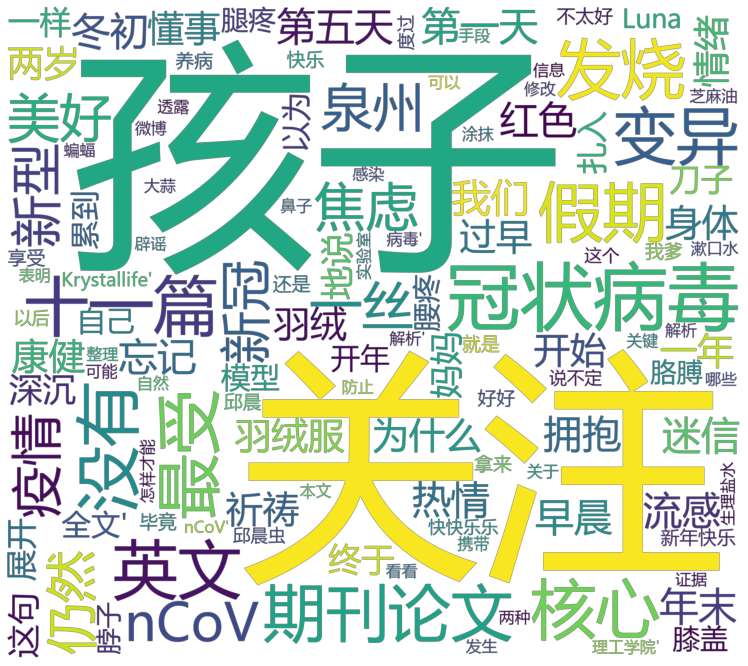

In [21]:
plt.figure(figsize=(14, 12))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

### 图片统计
在训练数据（微博）中，有些是有图片的，有些是没有图片的。

我们做一个简单统计：

In [22]:
train_labeled_copy['Pic_Length'] = train_labeled_copy['Pictures'].apply(lambda x: len(eval(x)))
test_copy['Pic_Length'] = test_copy['Pictures'].apply(lambda x: len(eval(x)))

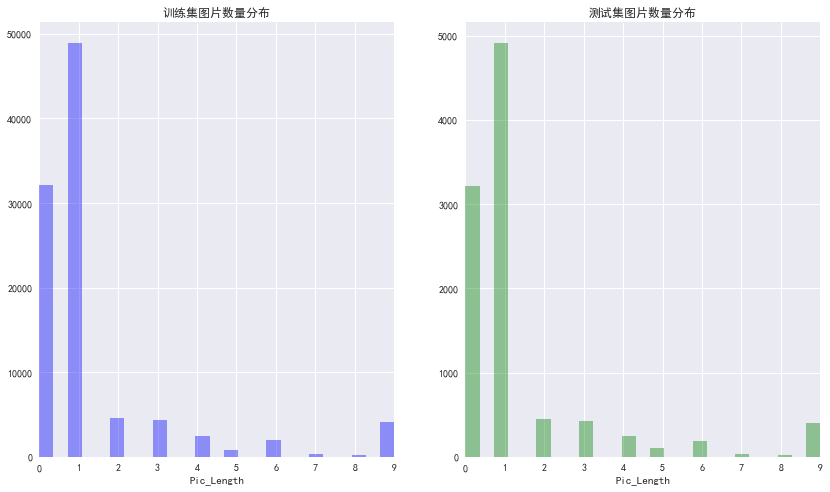

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))
ax1.set_xlim(0, 9)
ax2.set_xlim(0, 9)

sns.distplot(train_labeled_copy['Pic_Length'], bins=25, ax=ax1, color='blue', kde=False)
sns.distplot(test_copy['Pic_Length'], bins=25, ax=ax2, color='green', kde=False)

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

ax1.set_title('训练集图片数量分布')
ax2.set_title('测试集图片数量分布')

plt.show()

可以看出分布非常近似，这里基本没什么问题。

大多数人都是不发图片或者发一张图片。

至于9图比7、8图的多，6图比5图多，大概是强迫症...

### 视频统计

视频计数在训练集和测试集中分布：

In [24]:
train_labeled_copy['With_Video'] = train_labeled_copy['Videos'].apply(lambda x: len(eval(x)))
test_copy['With_Video'] = test_copy['Videos'].apply(lambda x: len(eval(x)))

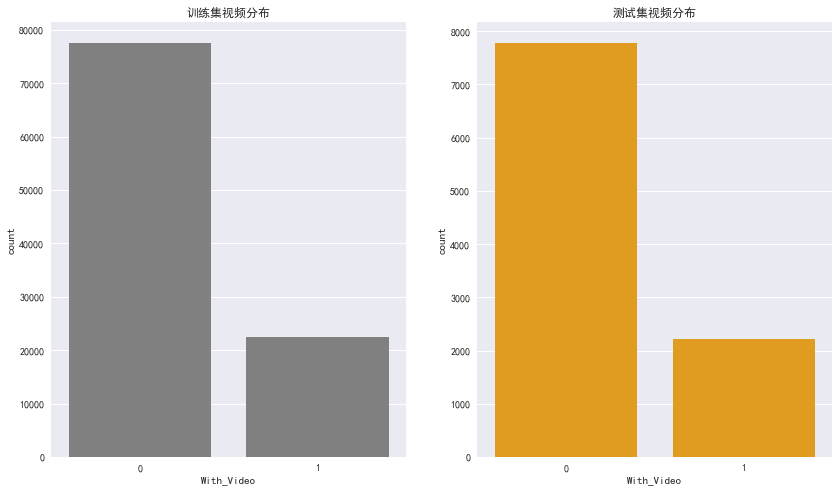

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

sns.countplot(train_labeled_copy['With_Video'], ax=ax1, color='grey')
sns.countplot(test_copy['With_Video'], ax=ax2, color='orange')

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

ax1.set_title('训练集视频分布')
ax2.set_title('测试集视频分布')

plt.show()

看起来分布是一致的。

接下来我们看看带视频和不带视频的情感标签分布。

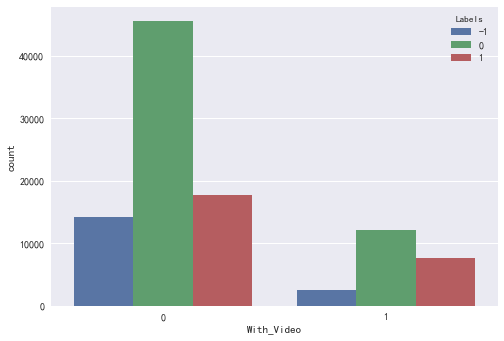

In [26]:
train_labeled_copy_2 = train_labeled_copy[(train_labeled_copy["Labels"] == '0') |
                                          (train_labeled_copy["Labels"] == '1') |
                                          (train_labeled_copy["Labels"] == '-1')]

sns.countplot(x='With_Video', hue='Labels', data= train_labeled_copy_2,
              order = train_labeled_copy['With_Video'].dropna().value_counts().index)
plt.show()

可以看出，大部分带视频的微博，其情感为中性。

但是明显的，相对于不带视频的微博，带视频的微博中 `正面情感` 比例比 `负面情感` 的比例更高。

## 含有负面词语的微博标签

如果有一些词语有强烈的感情色彩，那么他们的整体标签是怎么分布的？

实际上这涉及到了训练集标签到底是如何标注的，因为很多标签很迷，让我自己标都不一定能标对。

考虑做一个负面词云。

In [27]:
p = re.compile(r"伤心|难受|死亡|难过|孤独|疼痛|救救|焦虑|心慌|愤怒|生气|骂人|招谁惹谁|可怕|阴谋论")

train_labeled_copy['With_shangxin'] = train_labeled_copy['Chinese_Content'].apply(lambda x:0 if (p.search(str(x)) is None) else 1)  # 伤心
# test_copy['With_Video'] = test_copy['Videos'].apply(lambda x: len(eval(x)))

In [28]:
train_labeled_copy[train_labeled_copy["With_shangxin"] == 1]["Labels"].value_counts()

0              2244
-1             1952
1               420
empty_label       3
4                 1
9                 1
Name: Labels, dtype: int64

## 去除转发中的用户ID

In [55]:
def delete_repost_ID(text):
    reCmp1 = re.compile(r"(//@.*?:)", re.S)
    return re.sub(reCmp1, "//", text)

In [59]:
train_labeled_copy["Chinese_Content"] = train_labeled_copy["Chinese_Content"].astype(str).apply(lambda x: delete_repost_ID(x))

## 分情绪统计

### 负面情绪

In [62]:
neg_words_train = train_labeled_copy[train_labeled_copy['Labels'] == "-1"]

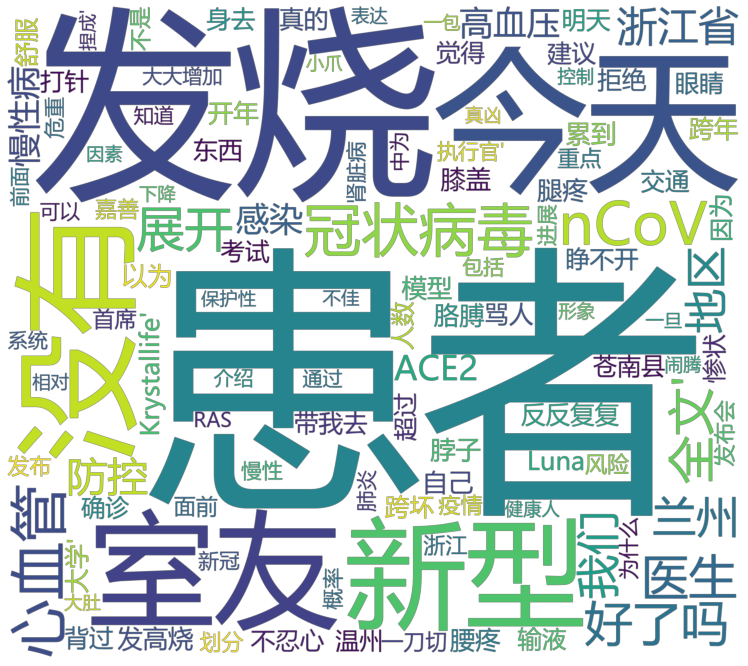

In [63]:
wc = WordCloud(font_path=font, 
               max_words=2000,
               width=1800, 
               height=1600, 
               mode='RGBA', 
               background_color=None).generate(str(neg_words_train['Chinese_Content_cut'].values))

plt.figure(figsize=(14, 12))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

### 中性情绪

In [64]:
normal_words_train = train_labeled_copy[train_labeled_copy['Labels'] == "0"]

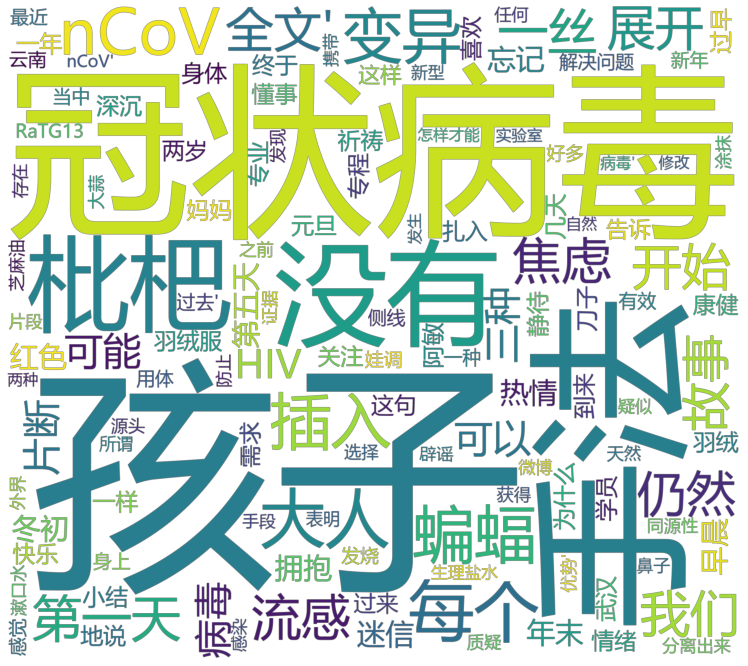

In [65]:
wc = WordCloud(font_path=font, 
               max_words=2000,
               width=1800, 
               height=1600, 
               mode='RGBA', 
               background_color=None).generate(str(normal_words_train['Chinese_Content_cut'].values))

plt.figure(figsize=(14, 12))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

### 正面情绪

In [66]:
pos_words_train = train_labeled_copy[train_labeled_copy['Labels'] == "1"]

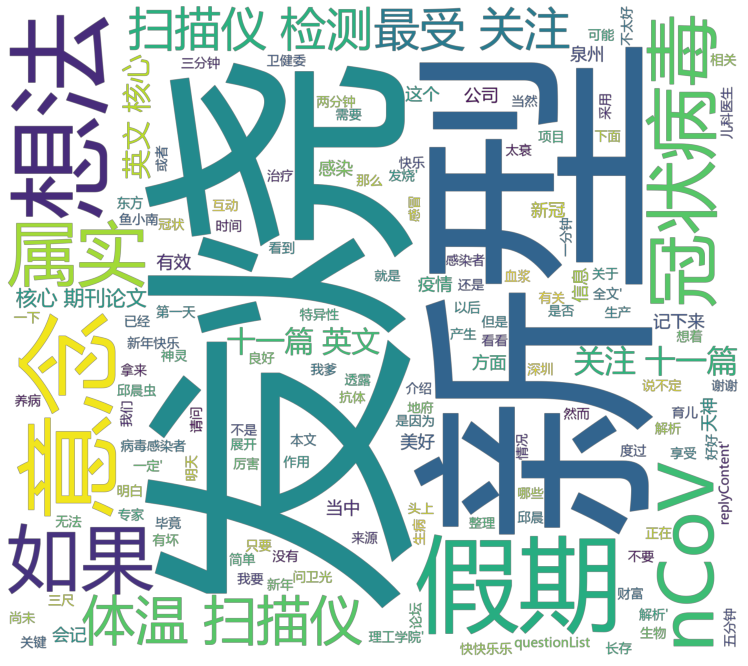

In [67]:
wc = WordCloud(font_path=font, 
               max_words=2000,
               width=1800, 
               height=1600, 
               mode='RGBA', 
               background_color=None).generate(str(pos_words_train['Chinese_Content_cut'].values))

plt.figure(figsize=(14, 12))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

### 负面情绪词语频数统计

In [68]:
all_neg_words = []
for cut_res in neg_words_train["Chinese_Content_cut"].values:
    res = cut_res.split(" ")
    for word in res:
        all_neg_words.append(word)

In [69]:
dic_1 = collections.Counter(all_neg_words)

In [70]:
# 对字典按value排序
neg_words_list = sorted(dic_1.items(), key=lambda x: x[1], reverse=True)
print(neg_words_list[0:100])

[('武汉', 3056), ('展开', 2708), ('全文', 2705), ('没有', 2659), ('疫情', 2546), ('口罩', 2218), ('真的', 2149), ('肺炎', 2112), ('自己', 2020), ('一个', 1913), ('确诊', 1897), ('现在', 1891), ('我们', 1781), ('病毒', 1748), ('什么', 1715), ('医院', 1698), ('这个', 1627), ('就是', 1514), ('不是', 1452), ('感染', 1449), ('病例', 1350), ('知道', 1306), ('新型', 1300), ('医生', 1252), ('今天', 1215), ('##', 1193), ('还是', 1155), ('已经', 1094), ('时候', 1066), ('患者', 1063), ('可以', 999), ('他们', 976), ('不能', 953), ('怎么', 924), ('上班', 919), ('这么', 917), ('因为', 914), ('隔离', 901), ('野味', 893), ('开始', 889), ('冠状病毒', 881), ('你们', 873), ('发烧', 847), ('大家', 842), ('看到', 812), ('不要', 798), ('中国', 785), ('还有', 781), ('这样', 763), ('为什么', 749), ('觉得', 736), ('可能', 732), ('微博', 730), ('蝙蝠', 707), ('希望', 693), ('如果', 692), ('这种', 690), ('视频', 677), ('但是', 676), ('工作', 661), ('湖北', 651), ('出来', 646), ('不会', 644), ('新冠', 640), ('那么', 639), ('咳嗽', 635), ('这些', 620), ('每天', 607), ('感觉', 602), ('一下', 600), ('全国', 596), ('一直', 585), ('问题', 569), ('在家', 565), ('那些

### 中性情绪词语频数统计

In [71]:
all_normal_words = []
for cut_res in normal_words_train["Chinese_Content_cut"].values:
    res = cut_res.split(" ")
    for word in res:
        all_normal_words.append(word)

In [72]:
dic_2 = collections.Counter(all_normal_words)

In [73]:
# 对字典按value排序
normal_words_list = sorted(dic_2.items(), key=lambda x: x[1], reverse=True)
print(normal_words_list[0:100])

[('肺炎', 16217), ('疫情', 15731), ('展开', 14670), ('全文', 14633), ('新型', 13451), ('武汉', 11315), ('冠状病毒', 10878), ('感染', 8405), ('病例', 7804), ('确诊', 7736), ('口罩', 7396), ('##', 6971), ('病毒', 6934), ('患者', 6656), ('医院', 6572), ('防控', 6003), ('我们', 5368), ('链接', 4976), ('没有', 4895), ('新冠', 4843), ('微博', 4834), ('网页', 4745), ('可以', 4540), ('视频', 4528), ('一个', 4341), ('工作', 4199), ('中国', 3904), ('自己', 3837), ('这个', 3835), ('隔离', 3715), ('大家', 3307), ('传播', 3239), ('湖北', 3160), ('2020', 3092), ('医生', 3081), ('目前', 3006), ('国家', 3004), ('就是', 2924), ('今天', 2923), ('新增', 2855), ('什么', 2824), ('现在', 2821), ('治疗', 2781), ('全国', 2706), ('出现', 2622), ('新闻', 2612), ('不要', 2568), ('健康', 2558), ('可能', 2479), ('不是', 2470), ('消毒', 2459), ('10', 2441), ('发现', 2418), ('专家', 2408), ('发热', 2406), ('出院', 2356), ('症状', 2339), ('需要', 2307), ('已经', 2304), ('时间', 2231), ('真的', 2206), ('发布', 2197), ('人员', 2194), ('知道', 2187), ('还是', 2185), ('情况', 2184), ('预防', 2146), ('希望', 2062), ('一起', 2040), ('开始', 2034), ('如果', 2

### 正面情绪词语频数统计

In [74]:
all_pos_words = []
for cut_res in pos_words_train["Chinese_Content_cut"].values:
    res = cut_res.split(" ")
    for word in res:
        all_pos_words.append(word)

In [75]:
dic_3 = collections.Counter(all_pos_words)

In [76]:
# 对字典按value排序
pos_words_list = sorted(dic_3.items(), key=lambda x: x[1], reverse=True)
print(pos_words_list[0:100])

[('加油', 10351), ('疫情', 8239), ('武汉', 8226), ('我们', 5811), ('中国', 5422), ('致敬', 4123), ('肺炎', 4007), ('展开', 3981), ('全文', 3972), ('一起', 3797), ('新型', 3449), ('##', 3377), ('希望', 2659), ('防控', 2504), ('行动', 2375), ('医院', 2340), ('一线', 2329), ('医护人员', 2203), ('自己', 2119), ('抗击', 2109), ('平安', 2065), ('大家', 2061), ('湖北', 1983), ('视频', 1935), ('一定', 1770), ('微博', 1741), ('冠状病毒', 1739), ('你们', 1735), ('一个', 1685), ('努力', 1660), ('口罩', 1613), ('患者', 1591), ('感谢', 1550), ('2020', 1542), ('工作', 1456), ('没有', 1437), ('真的', 1403), ('感染', 1395), ('可以', 1344), ('治愈', 1326), ('他们', 1309), ('这个', 1296), ('哈哈哈', 1289), ('医生', 1283), ('今天', 1230), ('肖战', 1227), ('健康', 1223), ('确诊', 1190), ('出院', 1189), ('所有', 1184), ('奋战', 1140), ('打卡', 1139), ('朱一龙', 1129), ('辛苦', 1117), ('公益', 1106), ('全国', 1097), ('病毒', 1096), ('就是', 1090), ('前线', 1077), ('战疫', 999), ('捐赠', 984), ('新冠', 978), ('起来', 957), ('打赢', 957), ('抗疫', 956), ('祈福', 955), ('链接', 954), ('病例', 948), ('人民', 945), ('白衣天使', 918), ('医疗队', 915), ('网页'

### 负面独有词汇统计

In [77]:
neg_only = []
for key in neg_words_list:
    if (key[0] not in dic_2) and (key[0] not in dic_3):
        neg_only.append(key)

In [78]:
neg_only[0:100]

[('出借', 22),
 ('之敌', 19),
 ('必死', 15),
 ('嘴瘾', 15),
 ('划掉', 15),
 ('广告创意', 14),
 ('即小三', 14),
 ('白牡丹', 14),
 ('对小王', 13),
 ('这心', 12),
 ('地痞流氓', 12),
 ('大肆宣传', 10),
 ('女厕所', 10),
 ('社达', 10),
 ('乙流', 9),
 ('讨饭', 9),
 ('痛心疾首', 9),
 ('翁秋秋', 9),
 ('私利', 9),
 ('黑恶势力', 9),
 ('犊子', 8),
 ('MWC', 8),
 ('活量', 8),
 ('死绝', 8),
 ('虫虫', 8),
 ('多行不义', 8),
 ('七世', 8),
 ('傻了眼', 8),
 ('Noki', 8),
 ('露马脚', 8),
 ('祁县', 8),
 ('遗言', 7),
 ('渣医', 7),
 ('连篇', 7),
 ('喷粪', 7),
 ('自毙', 7),
 ('没控', 7),
 ('泛案', 7),
 ('案中', 7),
 ('SARS2', 7),
 ('祭坛', 7),
 ('维以', 7),
 ('不永伤', 7),
 ('六义', 7),
 ('蒲塞', 7),
 ('Stradivari', 7),
 ('脑仁疼', 7),
 ('防弹衣', 7),
 ('nmd', 6),
 ('堵奶', 6),
 ('政令', 6),
 ('我活', 6),
 ('2829', 6),
 ('吃得下', 6),
 ('贱种', 6),
 ('狗日', 6),
 ('死不足惜', 6),
 ('失语', 6),
 ('气死人', 6),
 ('FindJapan', 6),
 ('香屯村', 6),
 ('违占', 6),
 ('问责云昆', 6),
 ('拦路抢劫', 6),
 ('还特', 6),
 ('噪声', 6),
 ('双牌县', 6),
 ('七弟', 6),
 ('DRAWCOOLxi', 6),
 ('税负', 6),
 ('邢立', 6),
 ('OldFanfan', 6),
 ('正常化', 6),
 ('糜烂', 5),
 ('咽不下', 5),
 ('豪华酒店', 5),

In [79]:
len(neg_only)

14164

In [80]:
for tup in neg_only[0:200]:
    print(tup[0])

出借
之敌
必死
嘴瘾
划掉
广告创意
即小三
白牡丹
对小王
这心
地痞流氓
大肆宣传
女厕所
社达
乙流
讨饭
痛心疾首
翁秋秋
私利
黑恶势力
犊子
MWC
活量
死绝
虫虫
多行不义
七世
傻了眼
Noki
露马脚
祁县
遗言
渣医
连篇
喷粪
自毙
没控
泛案
案中
SARS2
祭坛
维以
不永伤
六义
蒲塞
Stradivari
脑仁疼
防弹衣
nmd
堵奶
政令
我活
2829
吃得下
贱种
狗日
死不足惜
失语
气死人
FindJapan
香屯村
违占
问责云昆
拦路抢劫
还特
噪声
双牌县
七弟
DRAWCOOLxi
税负
邢立
OldFanfan
正常化
糜烂
咽不下
豪华酒店
高堂
其乐
融触
均告
二号线
mlgb
方没
红十
2103
死妈
额上
下三滥
廉租房
前也己
杀良
冒功
Kombrig
合法经营
wcnm
闲话
好端端
家屬
哭过
太多事
考列
取而代之
刘月
木叶
很傻
37.6
类学
卢英潭
uu
余温
红字
鲜血淋漓
阿忆
其转
李鸿印
招远
何性
追刑
不烦
至死不渝
阮念東
vicky
命顶
操者
别特
失芯
惶惶不可终日
死法
没退
O61
太无语
撞者
还花
明兮大
污人
涨红了脸
绽出
算编
算事
视奸
数多
cnmcnmcnm
十八层
行径
慌慌张张
糟蹋
乱子
CNM
杀人犯
奴役
瓊英
把柄
短寿
睡不醒
遭报应
一锅粥
如何是好
gz
肥志
游街示众
出镜
讷河
补退
腹地
小混蛋
充个
会费
国策
违建
雷劈
喜办
一言不合
山阴县
删微博
设下
栽下去
苦尝
小七赖
美云
手软
因排
枉死
不讲道理
买空
图个
活蹦乱跳
招黑
干吗
SB
老残
残残残
残残
乱串
李姑娘
吓死人
怎去
蚕蚀
大灰狼
Holee
看眼


### 中性独有词汇统计

In [81]:
norm_only = []
for key in normal_words_list:
    if (key[0] not in dic_1) and (key[0] not in dic_3):
        norm_only.append(key)

In [82]:
norm_only[0:100]

[('蓝光', 103),
 ('打底', 93),
 ('妆前', 88),
 ('腰果', 77),
 ('浅谈', 73),
 ('帮寻', 63),
 ('青兰', 51),
 ('全效', 51),
 ('亿人次', 46),
 ('A6Pk09lQ', 42),
 ('nbsp', 41),
 ('HiLink720', 40),
 ('轻薄', 39),
 ('60.8%', 39),
 ('72.7%', 39),
 ('66.6%', 39),
 ('每经', 39),
 ('超季', 39),
 ('十九时', 39),
 ('金九银', 39),
 ('静电', 39),
 ('微粒', 38),
 ('申论', 38),
 ('防水', 37),
 ('继续加强', 35),
 ('19.90', 34),
 ('大盘', 34),
 ('液态', 34),
 ('15g', 33),
 ('无毒', 31),
 ('实付', 31),
 ('165', 30),
 ('周泽发', 30),
 ('气血', 30),
 ('第六十二', 30),
 ('退名', 30),
 ('扬改', 30),
 ('故重', 30),
 ('乘禄', 30),
 ('自昌解', 30),
 ('24.9', 29),
 ('气阀', 29),
 ('干线', 29),
 ('原油', 29),
 ('含氯', 29),
 ('6700', 29),
 ('阳离子', 28),
 ('必抢', 28),
 ('股指', 28),
 ('绿豆', 28),
 ('桔梗', 28),
 ('配比', 28),
 ('温病', 27),
 ('收盘', 27),
 ('泌尿', 27),
 ('口服药物', 26),
 ('寻同', 26),
 ('现发', 26),
 ('气垫', 26),
 ('班线', 25),
 ('金丝', 25),
 ('京沪', 25),
 ('因雾', 25),
 ('寻狗', 25),
 ('做熟', 25),
 ('切除', 24),
 ('杆菌', 24),
 ('护眼', 24),
 ('速看', 24),
 ('危险品', 24),
 ('脊柱', 24),
 ('风机', 24),
 ('花草', 24),
 ('科

In [49]:
len(norm_only)

62897

In [83]:
for tup in norm_only[0:200]:
    print(tup[0])

蓝光
打底
妆前
腰果
浅谈
帮寻
青兰
全效
亿人次
A6Pk09lQ
nbsp
HiLink720
轻薄
60.8%
72.7%
66.6%
每经
超季
十九时
金九银
静电
微粒
申论
防水
继续加强
19.90
大盘
液态
15g
无毒
实付
165
周泽发
气血
第六十二
退名
扬改
故重
乘禄
自昌解
24.9
气阀
干线
原油
含氯
6700
阳离子
必抢
股指
绿豆
桔梗
配比
温病
收盘
泌尿
口服药物
寻同
现发
气垫
班线
金丝
京沪
因雾
寻狗
做熟
切除
杆菌
护眼
速看
危险品
脊柱
风机
花草
科技股
良品
中仅
时应
应立即
冲水
两款
柔韧
减速慢行
立交
防辐射
气虚
罗志祥
省界
棉纱
通俗
李莫愁
附着
可行性
脊髓灰质炎
考试院
托福考试
棕色
男科
子陵
VeroE6
nCoVEC50
试题
弹力
卷后
耐用
恶性肿瘤
亲子
益气
猫鼠
止痒
活性炭
胎菊
同仁堂
可操作性
买入
擦手
麦芽
平衡木
飞利浦
配戴
倾斜
大大降低
细胞膜
国省
69.00
麻疹
肤质
丛亮
做达芦
韦是
304
制成
瘙痒
萃取
白术
或活
尖锐湿疣
医养
奠定
乳胶
投保
环境污染
会商
行车道
美伊
体弱
茯苓
不锈钢
售票
45%
原装
聚卓
先码
9g
防护装置
读研
0.00
最全
组和
优惠价
防寒
-------------------------
男装
洋甘菊
补肾
桂林市
前体
新冠比
塌陷
分至
最新版
康巴
大广
小幅
假体
调适
午间
0.0024
特级
玉竹
小寒
研究家
考察组
王晓娟
明秀
护手
Hmmm
服帖
囟门
根管
维德
拉面馆
关键人物
整箱
置信度
沉积
接触性
蕾丝
光滑
5.8
薰衣草


### 正面独有词汇统计

In [50]:
pos_only = []
for key in pos_words_list:
    if (key[0] not in dic_1) and (key[0] not in dic_2):
        pos_only.append(key)

In [51]:
pos_only[0:100]

[('回甜馨', 112),
 ('抚养权', 112),
 ('mdxd', 43),
 ('源代码', 41),
 ('lyn', 41),
 ('走草路', 34),
 ('SourceCode', 28),
 ('待凛冬', 25),
 ('草青', 25),
 ('棚主', 23),
 ('张乔耳', 20),
 ('之河', 20),
 ('鲜语', 18),
 ('总群', 18),
 ('李一桐', 16),
 ('狠来', 16),
 ('一敏', 15),
 ('360417.88', 15),
 ('mxykaSophie', 14),
 ('歌友', 13),
 ('王琳凯', 13),
 ('精精有', 13),
 ('小沈龙', 13),
 ('欢迎光临', 12),
 ('圆之夜', 12),
 ('情深', 12),
 ('Androktasiai', 12),
 ('沙奎', 11),
 ('稍候', 11),
 ('非赢不可', 11),
 ('静儿', 11),
 ('板刷', 11),
 ('第十五', 11),
 ('黄廷', 11),
 ('种抗', 10),
 ('19000', 10),
 ('Loong', 10),
 ('小窝群', 10),
 ('果农', 10),
 ('Joer', 10),
 ('笑称', 10),
 ('吴安华', 10),
 ('Vampire', 10),
 ('awsl', 10),
 ('五福', 10),
 ('愿逆', 10),
 ('领金', 10),
 ('卡非佐米', 9),
 ('洒汗', 9),
 ('汪东城', 9),
 ('而安', 9),
 ('甜兴', 9),
 ('菠萝派', 9),
 ('precious', 9),
 ('Maybelline', 9),
 ('秃噜', 9),
 ('禾子', 9),
 ('人民解放军', 9),
 ('坚定信念', 9),
 ('准新娘', 9),
 ('pORA', 9),
 ('杨蓉', 9),
 ('一白张', 9),
 ('ruif', 9),
 ('唐莉佳', 9),
 ('最浅', 9),
 ('条幅', 8),
 ('无难', 8),
 ('投站', 8),
 ('中国青少年发展基金会', 8),
 ('

In [52]:
len(pos_only)

17310

In [53]:
gc.collect()

26856

In [85]:
for tup in pos_only[0:200]:
    print(tup[0])

回甜馨
抚养权
mdxd
源代码
lyn
走草路
SourceCode
待凛冬
草青
棚主
张乔耳
之河
鲜语
总群
李一桐
狠来
一敏
360417.88
mxykaSophie
歌友
王琳凯
精精有
小沈龙
欢迎光临
圆之夜
情深
Androktasiai
沙奎
稍候
非赢不可
静儿
板刷
第十五
黄廷
种抗
19000
Loong
小窝群
果农
Joer
笑称
吴安华
Vampire
awsl
五福
愿逆
领金
卡非佐米
洒汗
汪东城
而安
甜兴
菠萝派
precious
Maybelline
秃噜
禾子
人民解放军
坚定信念
准新娘
pORA
杨蓉
一白张
ruif
唐莉佳
最浅
条幅
无难
投站
中国青少年发展基金会
封面人物
长命百岁
蒸蒸日上
迎福
瓷瓷
Hanasa
花洒
xfxxzgg
歌好
欧豪
鬼王
宗副
宗主
鬼厉
Makerforce
平潭
茅子
挺立
Adam0616
领命
李圆霸
0.16
为雷
年刊
大男主
雷米迪维
或伦地
小懒菌
雨余秋清
花缪子
BAZZALX
之恒
如日
之升
要流
1905
尤莲
静等
七绝
苏有朋
阖家幸福
2540
于省
娄勤俭
捷讯
多支
Samuel
最爱猴
再遇
Boogie
小芋
海军陆战队
小兴
0202
chachalacha
望峰
宇航
泼墨
少先队员
新疆医科大学
小燕
嗜肉菌
爱徒
一龙
艳遇
牦牛
感怀
1025
终局
奎星阁
89792
印痕
画小眉
唯爱
垄上
李葱
同气连枝
亨圈
咖图
疑问句
洪一诺
10930
原州区
马里
碰拳
为暖心
玉泉区
哈萨克斯坦
水桥
宏愿
记君
为森
得控
热忱地
百无禁忌
冲刺班
父老
光和热
小赖
李冲
谦恭
最甜
707
肖砚
会救
相托
精忠
ZTAO
江上
用爱疗
愈和凯
知恩图报
枪手
富光
源阅
有源
willa
lau
KrisBar
小虎
太赞
Official
救命之恩
团员青年
寄星
0202.4
肖兔紙
Vanessa
同仇敌忾
A6Pfslok


## 对于非标注数据集应用独有词汇标注\

### 正面

In [102]:
train_unlabeled = pd.read_csv('./input/train_dataset/nCoV_900k_train_unlabled_utf8.csv', encoding='utf-8')
train_unlabeled.rename(columns = {"微博id": "Weibo_ID",
                                "微博发布时间": "Publish_Time", 
                                "发布人账号": "Account_ID",
                                "微博中文内容": "Chinese_Content",
                                "微博图片": "Pictures",
                                "微博视频": "Videos",
                                "情感倾向": "Labels"},  inplace=True)

train_unlabeled_copy = train_unlabeled.copy()

In [103]:
# 提取三种独有高频词语放入set
pos_set = set()
sep = "|"

# 读取正面文档
with open("正面词.txt", "r", encoding='utf-8') as f:
    for line in f.readlines():
        line = line.strip('\n')
        pos_set.add(line)
f.close()

In [104]:
len(pos_set)

96

In [105]:
# for word in pos_only[0:150]:
#     pos_set.add(word[0])

# 粉丝
pos_set.add("后援会")
pos_set.add("后援团")
pos_set.add("韩红")

# 宗教
pos_set.add("观音菩萨")
pos_set.add("文殊菩萨")



pos_string = sep.join(pos_set)

In [106]:
len(pos_set)

98

In [107]:
pos_string = sep.join(pos_set)

In [108]:
print(pos_string)

种抗|少先队员|稍候|抚养权|唐莉佳|静儿|中国青少年发展基金会|一龙|蒸蒸日上|鬼厉|知恩图报|板刷|年刊|吴安华|同仇敌忾|花洒|源代码|菠萝派|愿逆|宇航|Maybelline|封面人物|黄廷|圆之夜|洪一诺|歌友|百无禁忌|小兴|欧豪|艳遇|为雷|救命之恩|王琳凯|迎福|人民解放军|长命百岁|小虎|小沈龙|热忱地|父老|同气连枝|宏愿|卡非佐米|情深|Vampire|韩红|光和热|秃噜|哈萨克斯坦|谦恭|唯爱|第十五|文殊菩萨|Official|果农|回甜馨|雷米迪维|爱徒|冲刺班|坚定信念|后援会|李冲|杨蓉|大男主|草青|李圆霸|棚主|一敏|海军陆战队|嗜肉菌|最甜|欢迎光临|领命|宗副|张乔耳|沙奎|李一桐|lyn|团员青年|玉泉区|笑称|鲜语|禾子|苏有朋|小窝群|五福|非赢不可|肖砚|阖家幸福|领金|准新娘|奎星阁|后援团|宗主|汪东城|狠来|观音菩萨|为暖心


In [109]:
pattern_pos = re.compile(pos_string)


train_unlabeled_copy["Labels_pos"] = train_unlabeled_copy['Chinese_Content'].apply(lambda x:"2" if (pattern_pos.search(str(x)) is None) else "1")  

In [110]:
train_unlabeled_copy_pos = train_unlabeled_copy[train_unlabeled_copy["Labels_pos"] == "1"]

### 负面

In [111]:
# 提取三种独有高频词语放入set
neg_set = set()
sep = "|"

# 读取正面文档
with open("负面词.txt", "r", encoding='utf-8') as f:
    for line in f.readlines():
        line = line.strip('\n')
        neg_set.add(line)
f.close()

In [107]:
neg_string = sep.join(neg_set)

In [112]:
# 手动干掉不合适的 - 负面
not_negs = ["噪声", "糜烂", "失语", "均告", "划掉", "咽不下", "嘴瘾", "撞者"]
for not_neg in not_negs:
    neg_set.discard(not_neg)

neg_set.add("nmsl")
neg_set.add("NMSL")
neg_set.add("NM$L")
neg_set.add("憨批")
neg_set.add("带孝子")
neg_set.add("学术腐败")
neg_set.add("道德绑架")
neg_set.add("黑子")

neg_string = sep.join(neg_set)

In [113]:
print(neg_string)

地痞流氓|雷劈|手软|下三滥|残残残|残残|学术腐败|SB|税负|憨批|哭过|杀人犯|栽下去|死妈|NM$L|追刑|CNM|鲜血淋漓|傻了眼|视奸|枉死|删微博|拦路抢劫|mlgb|气死人|犊子|十八层|买空|祭坛|讨饭|女厕所|SARS2|吓死人|死法|睡不醒|痛心疾首|喷粪|脑仁疼|乱子|慌慌张张|苦尝|nmsl|问责云昆|如何是好|闲话|太无语|死不足惜|招黑|数多|奴役|失芯|蚕蚀|一锅粥|必死|违建|不讲道理|私利|惶惶不可终日|渣医|死绝|出借|nmd|大肆宣传|NMSL|之敌|违占|游街示众|多行不义|一言不合|道德绑架|wcnm|遭报应|很傻|把柄|黑恶势力|糟蹋|老残|干吗|活蹦乱跳|李鸿印|小混蛋|贱种|自毙|这心|cnmcnmcnm|带孝子|乙流|不烦|狗日|露马脚|短寿|黑子|遗言|行径|因排


In [114]:
pattern_neg = re.compile(neg_string)

train_unlabeled_copy["Labels_neg"] = train_unlabeled_copy['Chinese_Content'].apply(lambda x:"2" if (pattern_neg.search(str(x)) is None) else "-1")  

In [115]:
train_unlabeled_copy_neg = train_unlabeled_copy[train_unlabeled_copy["Labels_neg"] == "-1"]

### 中性

In [118]:
# 提取三种独有高频词语放入set
norm_set = set()
sep = "|"

# 读取正面文档
with open("中性词.txt", "r", encoding='utf-8') as f:
    for line in f.readlines():
        line = line.strip('\n')
        norm_set.add(line)
f.close()

In [119]:
norm_string = sep.join(norm_set)

In [120]:
# 手动干掉不合适的
not_norms = ["HiLink720", "69.00", "6700", "A6Pk09lQ", "24.9", "165", "66.6%", 
             "304", "60.8%", "45%", "72.7%", "19.90", "宇航", "倾斜", "韦是"]
for not_norm in not_norms:
    norm_set.discard(not_norm)

# 带货
norm_set.add("元包邮")
norm_set.add("券后")
norm_set.add("折上折")

# 新闻
norm_set.add("新闻发言人")
norm_set.add("领导小组")
norm_set.add("办公室主任")
norm_set.add("紧急通知")
norm_set.add("小知识")
norm_set.add("微博辟谣")
norm_set.add("政府公告")
    
norm_string = sep.join(norm_set)

In [121]:
print(norm_string)

活性炭|附着|投保|亲子|先码|防护装置|瘙痒|不锈钢|小幅|立交|妆前|含氯|洋甘菊|冲水|配比|新冠比|无毒|益气|寻狗|男装|塌陷|青兰|午间|维德|肤质|因雾|飞利浦|实付|泌尿|护眼|干线|气虚|省界|聚卓|折上折|关键人物|止痒|试题|王晓娟|现发|光滑|最全|奠定|会商|花草|静电|细胞膜|根管|读研|班线|气阀|绿豆|做达芦|申论|必抢|体弱|最新版|切除|蓝光|耐用|麻疹|医养|政府公告|平衡木|玉竹|京沪|温病|做熟|新闻发言人|拉面馆|故重|领导小组|时应|囟门|继续加强|可操作性|白术|乳胶|金九银|防辐射|托福考试|康巴|胎菊|阳离子|大盘|麦芽|股指|每经|气血|原油|十九时|亿人次|打底|男科|应立即|萃取|组和|气垫|置信度|考试院|补肾|超季|同仁堂|口服药物|擦手|或活|茯苓|扬改|全效|棕色|假体|危险品|恶性肿瘤|元包邮|明秀|小知识|良品|配戴|大广|环境污染|可行性|第六十二|薰衣草|防水|卷后|桂林市|棉纱|帮寻|买入|丛亮|罗志祥|原装|弹力|整箱|通俗|李莫愁|脊髓灰质炎|轻薄|特级|接触性|防寒|分至|速看|科技股|减速慢行|杆菌|液态|服帖|美伊|微博辟谣|大大降低|柔韧|微粒|国省|子陵|考察组|退名|制成|行车道|脊柱|两款|猫鼠|优惠价|浅谈|办公室主任|腰果|收盘|风机|金丝|前体|护手|尖锐湿疣|蕾丝|中仅|售票|调适|紧急通知|小寒|研究家|桔梗|寻同|券后|沉积


In [122]:
pattern_norm = re.compile(norm_string)


train_unlabeled_copy["Labels_norm"] = train_unlabeled_copy['Chinese_Content'].apply(lambda x:"2" if (pattern_norm.search(str(x)) is None) else "0")  

In [123]:
train_unlabeled_copy_norm = train_unlabeled_copy[train_unlabeled_copy["Labels_norm"] == "0"]

### 拼接

In [124]:
frames = [train_unlabeled_copy_norm, train_unlabeled_copy_neg, train_unlabeled_copy_pos]

In [125]:
result = pd.concat(frames)

In [126]:
result = result.drop_duplicates(subset=['Chinese_Content'], keep='first')

In [127]:
result.to_csv("extra_labels_utf8.csv", index=False)
result.to_csv("extra_labels_ANSI.csv", encoding='gb18030', index=False)

### 整合

In [121]:
# norm
result_norm = result[(result["Labels_pos"] == "2") & (result["Labels_neg"] == "2")]
result_norm['Labels'] = "0"

In [122]:
# neg
result_neg = result[(result["Labels_pos"] == "2") & (result["Labels_neg"] == "-1")]
result_neg['Labels'] = "-1"

In [123]:
# pos
result_pos = result[(result["Labels_pos"] == "1") & (result["Labels_neg"] != "-1")]
result_pos['Labels'] = "1"

In [124]:
result_norm.shape

(25972, 10)

In [125]:
result_neg.shape

(4587, 10)

In [126]:
result_pos.shape

(15761, 10)

In [127]:
frames_2 = [result_norm, result_neg, result_pos]

In [128]:
labeled_result = pd.concat(frames_2)

In [129]:
labeled_result = labeled_result.drop(['Labels_pos', 'Labels_norm', 'Labels_neg'], axis=1)

In [130]:
labeled_result.to_csv("final_labels_utf8.csv", index=False)
labeled_result.to_csv("final_labels_ANSI.csv", encoding='gb18030', index=False)

In [ ]:
# 最后记得拼接起来就行了

In [97]:
check = "#每日一黑台湾省#还是得提醒各位我们这边忙着抗新型肺炎的时候，台湾又在给自己加戏码1.台湾防疫指挥中心提醒，如自武汉及其邻近区域来台，入境时，如出现发烧、咳嗽、呼吸急促等症状，无论是否服用退烧药、止咳药，请主动向机场或港口检疫人员报到，接受健康评估，如未据实通报将会处以罚锾，最高15?展开全文c"

In [98]:
pattern_neg.search(str(check))

In [99]:
pattern_pos.search(str(check))

In [100]:
pattern_norm.search(str(check))

<re.Match object; span=(73, 75), match='现发'>

## 替换用户名

用户转发的内容通常是

`//@失落宇航员:` 形式，需要写个正则替换。

例句：

"来了！//@一也行一:气死我了气死我了气死我了，洗完澡就带妆？头发秒干？你究竟藏了什么好用的高科技？求速分享！众所周知别人发烧时不要摸额头会八级烫伤(说胡话中//@只是忘记好多:老公老公！！！！//@哔哩吧la哔哩吧la:@只是忘记好多集美快来!是你的郎君!"

In [2]:
test = "来了！//@一也行一:气死我了气死我了气死我了，洗完澡就带妆？头发秒干？你究竟藏了什么好用的高科技？求速分享！众所周知别人发烧时不要摸额头会八级烫伤(说胡话中//@只是忘记好多:老公老公！！！！//@哔哩吧la哔哩吧la:@只是忘记好多集美快来!是你的郎君!"

In [14]:
reCmp1 = re.compile(r"(//@.*?:)", re.S)
# reCmp2 = re.compile(r"(/)(/@.*?)(:)", re.S)
print(reCmp1.findall(test))

['//@一也行一:', '//@只是忘记好多:', '//@哔哩吧la哔哩吧la:']


In [17]:
len(reCmp1.findall(test))

3

In [16]:
re.sub(reCmp1, "//", test)

'来了！//气死我了气死我了气死我了，洗完澡就带妆？头发秒干？你究竟藏了什么好用的高科技？求速分享！众所周知别人发烧时不要摸额头会八级烫伤(说胡话中//老公老公！！！！//@只是忘记好多集美快来!是你的郎君!'

### 结语

后续看空闲再更新吧...希望这份简单的EDA对大家有所帮助。